<a href="https://colab.research.google.com/github/Shahid0120/ml-mini-projects/blob/main/forcasting_stateful_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forecasting with Statful RNN's**

Shahid Hussain 8th December 2023

The following notebook is done after watching MIT lecture of RNN's + Udacity tensoreflow introduction. This will forcast times series using time window using statful RNN's

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# y = mx + b so this is mx
def trend(time, slope=0):
  return slope * time



def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

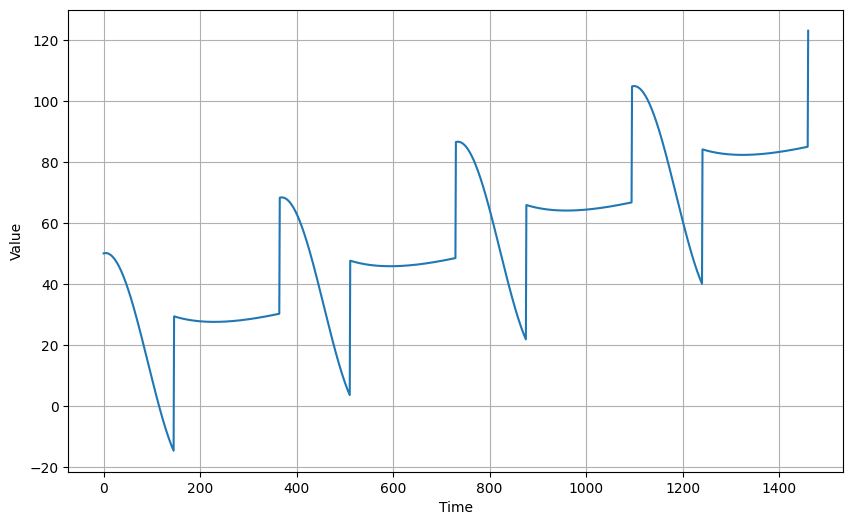

In [9]:
# creating artificial data trends
# creaates 4 years of days x points
time = np.arange(4 * 365 + 1)

slope = 0.05
amplitude = 40

# shifts up and down graph b term in y = mx + b
baseline = 10

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

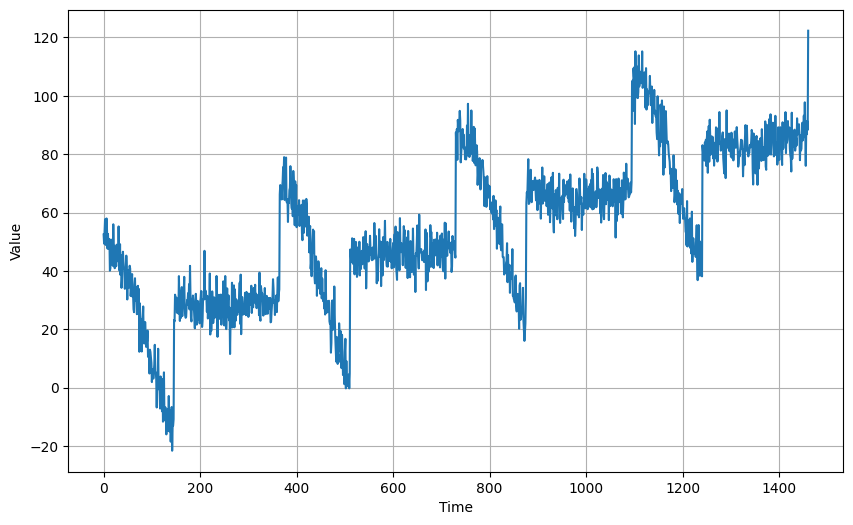

In [10]:
# creating artificial data trends
# creaates 4 years of days x points
time = np.arange(4 * 365 + 1)

slope = 0.05
amplitude = 40

# shifts up and down graph b term in y = mx + b
baseline = 10

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# adding noise
noise_level = 5
noise = white_noise(time, noise_level, seed=42)
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Statful RNN forcasting

In [15]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


In [16]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [17]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 13ms/step - loss: 531.4349 - mae: 531.9348 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 496.0405 - mae: 496.5405 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 456.3069 - mae: 456.8069 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 414.2138 - mae: 414.7138 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 11ms/step - loss: 369.6750 - mae: 370.1750 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 323.7286 - mae: 324.2286 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 276.7759 - mae: 277.2759 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 227.4911 - mae: 227.9911 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 11ms/step - loss

(1e-08, 0.0001, 0.0, 30.0)

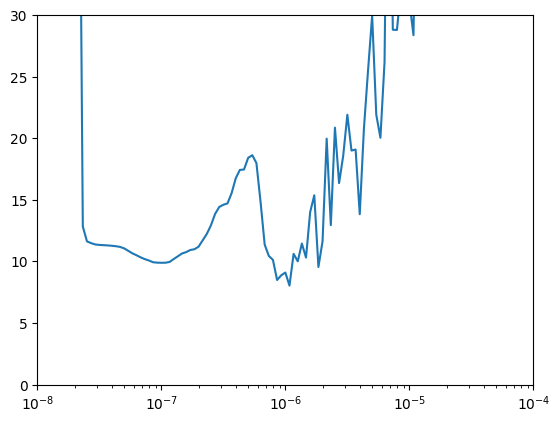

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [20]:
# fix the learning rate to about 1e-7
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 8s 92ms/step - loss: 47504.8125 - mae: 47505.3125 - val_loss: 15826.9619 - val_mae: 15827.4600


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
33/33 [==============================] - 1s 15ms/step - loss: 27817.0566 - mae: 27817.5566 - val_loss: 52951.6133 - val_mae: 52952.1172
Epoch 3/500
33/33 [==============================] - 1s 22ms/step - loss: 36594.1797 - mae: 36594.6836 - val_loss: 53999.1133 - val_mae: 53999.6094
Epoch 4/500
33/33 [==============================] - 1s 31ms/step - loss: 30357.8789 - mae: 30358.3789 - val_loss: 56735.4766 - val_mae: 56735.9727
Epoch 5/500
33/33 [==============================] - 1s 31ms/step - loss: 38541.8008 - mae: 38542.2969 - val_loss: 14513.2080 - val_mae: 14513.7090
Epoch 6/500
33/33 [==============================] - 1s 31ms/step - loss: 50157.6836 - mae: 50158.1797 - val_loss: 12845.4209 - val_mae: 12845.9209
Epoch 7/500
33/33 [==============================] - 1s 24ms/step - loss: 99620.2969 - mae: 99620.7969 - val_loss: 126869.7266 - val_mae: 126870.2344
Epoch 8/500
33/33 [==============================] - 1s 32ms/step - loss: 51005.0703 - mae: 51005.5625 - val_l

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [ ]:
rnn_forecast.shape

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()